<a href="https://colab.research.google.com/github/mferuscomelo/fall-detection/blob/main/fall_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Adapted from https://arxiv.org/ftp/arxiv/papers/1911/1911.11976.pdf

In [38]:
!git clone https://github.com/mferuscomelo/fall-detection.git

fatal: destination path 'fall-detection' already exists and is not an empty directory.


In [39]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from scipy import signal
from scipy.stats import kurtosis, skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42
COLUMN_NAMES = ["acc1_x", "acc1_y", "acc1_z", "gyro_x", "gyro_y", "gyro_z", "acc2_x", "acc2_y", "acc2_z"]

In [40]:
dataset_dir = "/content/fall-detection/dataset"

adl_filepaths = []
fall_filepaths = []

for subdir, dirs, files in os.walk(dataset_dir):
  for file in files:
    # make sure that only csv files are included
    if "csv" not in file:
      continue

    path = os.path.join(subdir, file)

    if file[0] == "D":
      adl_filepaths.append(path)
    elif file[0] == "F":
      fall_filepaths.append(path)

In [41]:
def convert_data(data_bits, range: int, resolution: int):
  # Equation = [(2*Range)/(2^Resolution)]*Data
  data_converted = data_bits * ((2 * range) / (2 ** resolution))
  return data_converted

In [42]:
def filter_data(data):
  b, a = signal.butter(4, 5, fs=200, btype='lowpass', analog=False)
  return signal.filtfilt(b, a, data)

In [43]:
def mean(data):
  return np.mean(data)

def std(data):
  return np.std(data)

def extract_features(df):
  features = []
  col_names = []

  for sensor_name in ["acc1_x", "acc1_y", "acc1_z", "gyro_x", "gyro_y", "gyro_z", "acc2_x", "acc2_y", "acc2_z"]:
    for variable_type in ["max_amp", "min_amp", "mean_amp", "variance", "kurtosis", "skewness"]:
        col_names.append(f"{sensor_name}_{variable_type}")

  row = []
  for col in df:
    col_data = df[col]

    row.append(max(col_data)) # maximum amplitude
    row.append(min(col_data)) # minimum amplitude
    row.append(mean(col_data)) # mean amplitude
    row.append(std(col_data)) # variance
    row.append(kurtosis(col_data)) # kurtosis
    row.append(skew(col_data)) # skewness

  features.append(row)

  features_df = pd.DataFrame(features, columns=col_names)

  return features_df


In [44]:
def calc_features_df(filepath: str, class_num=-1, is_raw=True):
  df = pd.read_csv(filepath, names=COLUMN_NAMES, header=None)

  for axis in ["x", "y", "z"]:
    acc1_data = df[f"acc1_{axis}"]
    acc2_data = df[f"acc2_{axis}"]
    gyro_data = df[f"gyro_{axis}"]

    # Convert data if data is raw
    if is_raw:
      acc1_data = convert_data(acc1_data, 16, 13)
      acc2_data = convert_data(acc2_data, 8, 14)
      gyro_data = convert_data(gyro_data, 2000, 16)

    # Filter data using a Butterworth filter
    df[f"acc1_{axis}"] = filter_data(acc1_data)
    df[f"acc2_{axis}"] = filter_data(acc2_data)
    df[f"gyro_{axis}"] = filter_data(gyro_data)

  features_df = extract_features(df)

  if class_num >= 0:
    features_df["class"] = np.full(len(features_df), class_num)

  return features_df

In [45]:
adl_df_list = []
fall_df_list = []

for file in adl_filepaths:
  features_df = calc_features_df(file, 0)
  adl_df_list.append(features_df)

for file in fall_filepaths:
  features_df = calc_features_df(file, 1)
  fall_df_list.append(features_df)

adl_df = pd.concat(adl_df_list, sort=False, ignore_index=True)
fall_df = pd.concat(fall_df_list, sort=False, ignore_index=True)

In [46]:
print(len(adl_df), "rows,", len(adl_df.columns), "cols")
adl_df.head()

2707 rows, 55 cols


,acc1_x_max_amp,acc1_x_min_amp,acc1_x_mean_amp,acc1_x_variance,acc1_x_kurtosis,acc1_x_skewness,acc1_y_max_amp,acc1_y_min_amp,acc1_y_mean_amp,acc1_y_variance,acc1_y_kurtosis,acc1_y_skewness,acc1_z_max_amp,acc1_z_min_amp,acc1_z_mean_amp,acc1_z_variance,acc1_z_kurtosis,acc1_z_skewness,gyro_x_max_amp,gyro_x_min_amp,gyro_x_mean_amp,gyro_x_variance,gyro_x_kurtosis,gyro_x_skewness,gyro_y_max_amp,gyro_y_min_amp,gyro_y_mean_amp,gyro_y_variance,gyro_y_kurtosis,gyro_y_skewness,gyro_z_max_amp,gyro_z_min_amp,gyro_z_mean_amp,gyro_z_variance,gyro_z_kurtosis,gyro_z_skewness,acc2_x_max_amp,acc2_x_min_amp,acc2_x_mean_amp,acc2_x_variance,acc2_x_kurtosis,acc2_x_skewness,acc2_y_max_amp,acc2_y_min_amp,acc2_y_mean_amp,acc2_y_variance,acc2_y_kurtosis,acc2_y_skewness,acc2_z_max_amp,acc2_z_min_amp,acc2_z_mean_amp,acc2_z_variance,acc2_z_kurtosis,acc2_z_skewness,class
0,0.412097,-0.303774,0.126126,0.144271,0.565948,-0.941661,-0.707385,-1.227144,-0.893830,0.125537,-1.507645,0.215210,0.530227,-0.450715,0.199353,0.258235,-1.095572,-0.171213,63.748601,-56.633065,-1.827388,13.599294,6.353371,0.762342,78.589460,-30.138097,6.235331,17.253348,3.873340,1.908662,38.685831,-44.929529,-0.598020,9.878188,5.447945,-0.390012,0.318612,-0.375474,0.044213,0.141603,0.503574,-0.927169,-0.676625,-1.174784,-0.855197,0.120659,-1.503280,0.217944,0.687337,-0.288297,0.355416,0.259948,-1.132065,-0.142152,0
1,0.491542,-0.415073,0.101778,0.136026,1.213895,-0.658707,-0.657881,-1.307803,-0.924635,0.132801,-0.982005,0.630014,0.538722,-0.423024,0.111373,0.269691,-1.162368,0.497064,89.360210,-64.497903,-1.779129,14.561697,12.380192,1.264304,112.594344,-69.883610,6.184255,22.067360,6.315800,1.518098,30.024753,-58.368394,-0.967113,9.943291,8.853898,-1.372838,0.388476,-0.482881,0.020174,0.132813,1.134641,-0.653784,-0.629622,-1.245999,-0.884762,0.127478,-0.996371,0.634465,0.701763,-0.262944,0.268919,0.271371,-1.165600,0.515765,0
2,0.265877,-0.032369,0.076720,0.033277,10.009849,2.399069,0.191649,-1.953686,-1.011991,0.219400,13.320995,1.690780,0.066551,-0.572786,-0.177859,0.152284,-0.369353,-0.241057,69.900334,-72.046531,-2.889520,17.450692,5.187211,0.583232,41.329687,-26.380044,0.954596,6.543946,9.822015,0.629680,21.773085,-22.583484,-0.227446,4.007090,10.955940,0.003283,0.164429,-0.113395,-0.005920,0.031382,9.138401,2.178734,0.203495,-1.874433,-0.966913,0.212791,13.398848,1.745463,0.215449,-0.430669,-0.020066,0.152527,-0.257186,-0.336455,0
3,0.156726,-0.004237,0.037811,0.029219,1.590803,1.592599,-0.145385,-1.826950,-1.005140,0.160868,13.734447,0.228093,-0.052596,-0.598230,-0.308335,0.108674,0.661647,0.794933,122.439791,-71.596842,-2.600450,16.519920,21.671557,1.895508,15.025690,-6.816347,0.935510,2.497011,7.558865,1.266827,10.020733,-20.275331,-0.344914,2.469550,24.597123,-2.348389,0.072149,-0.090342,-0.042772,0.027575,1.608027,1.567786,-0.113814,-1.750274,-0.958808,0.156954,13.720001,0.301453,0.102243,-0.443101,-0.151779,0.108934,0.652021,0.767577,0
4,0.425174,-0.166611,0.098557,0.090057,-0.664547,-0.147379,-0.746609,-1.391248,-1.009705,0.133280,-0.405639,-0.882972,0.044465,-0.707117,-0.317861,0.141301,-0.321595,-0.615018,28.161244,-33.793449,-2.632289,8.262721,0.118679,-0.065733,70.221652,-56.167737,2.705810,19.784358,-0.137040,-0.020527,34.729032,-33.307872,-0.138942,12.484283,-0.860298,0.080220,0.319527,-0.240538,0.013599,0.086444,-0.676464,-0.155681,-0.711275,-1.332885,-0.961590,0.130121,-0.381355,-0.903563,0.191230,-0.558937,-0.162538,0.142994,-0.329289,-0.634552,0


In [47]:
print(len(fall_df), "rows,", len(fall_df.columns), "cols")
fall_df.head()

1798 rows, 55 cols


,acc1_x_max_amp,acc1_x_min_amp,acc1_x_mean_amp,acc1_x_variance,acc1_x_kurtosis,acc1_x_skewness,acc1_y_max_amp,acc1_y_min_amp,acc1_y_mean_amp,acc1_y_variance,acc1_y_kurtosis,acc1_y_skewness,acc1_z_max_amp,acc1_z_min_amp,acc1_z_mean_amp,acc1_z_variance,acc1_z_kurtosis,acc1_z_skewness,gyro_x_max_amp,gyro_x_min_amp,gyro_x_mean_amp,gyro_x_variance,gyro_x_kurtosis,gyro_x_skewness,gyro_y_max_amp,gyro_y_min_amp,gyro_y_mean_amp,gyro_y_variance,gyro_y_kurtosis,gyro_y_skewness,gyro_z_max_amp,gyro_z_min_amp,gyro_z_mean_amp,gyro_z_variance,gyro_z_kurtosis,gyro_z_skewness,acc2_x_max_amp,acc2_x_min_amp,acc2_x_mean_amp,acc2_x_variance,acc2_x_kurtosis,acc2_x_skewness,acc2_y_max_amp,acc2_y_min_amp,acc2_y_mean_amp,acc2_y_variance,acc2_y_kurtosis,acc2_y_skewness,acc2_z_max_amp,acc2_z_min_amp,acc2_z_mean_amp,acc2_z_variance,acc2_z_kurtosis,acc2_z_skewness,class
0,0.210565,-1.101907,-0.020830,0.127924,22.438902,-3.298124,1.392266,-1.665785,-0.571892,0.575891,-0.560208,0.572291,0.522093,-3.619608,-0.586501,0.532230,2.820168,-1.055815,219.176512,-185.386085,-7.328943,30.621443,20.940250,-1.324519,151.255084,-168.420949,6.553205,27.136941,12.039490,-1.087472,41.266908,-100.602810,-0.661056,14.181704,8.572317,-1.126540,0.114027,-1.326136,-0.107821,0.134885,29.362095,-3.964723,1.477507,-1.565587,-0.528778,0.570739,-0.438765,0.602115,0.686572,-3.296071,-0.429350,0.528415,1.939131,-0.926832,1
1,0.328092,-1.772087,-0.062102,0.188484,39.501370,-5.057499,1.083230,-2.583497,-0.259969,0.744293,1.132067,-1.415223,0.436820,-3.308003,-0.799042,0.481664,1.567512,-0.049492,82.152109,-340.619084,-7.326340,33.940432,44.207903,-5.526888,160.986147,-99.271681,1.955606,35.212347,4.226314,0.990680,121.931121,-61.483640,1.521666,19.679819,9.419445,1.878097,0.235147,-1.650284,-0.144257,0.167670,34.304458,-4.403165,0.965006,-2.498689,-0.228354,0.725750,1.121657,-1.438051,0.591903,-3.028193,-0.641454,0.478156,1.020399,0.063374,1
2,0.362188,-3.109164,-0.274288,0.406382,7.671631,-1.610960,1.190902,-2.140036,-0.427675,0.597922,-1.294408,0.005417,0.944130,-0.530041,0.185048,0.408078,-1.697582,-0.032409,132.885128,-81.478373,-3.719630,16.406019,26.206824,2.101718,113.975799,-256.139440,2.028132,39.634340,11.508351,-2.240819,292.764548,-42.350301,6.120248,34.512846,36.054287,5.477457,0.269206,-3.091767,-0.346418,0.392960,7.695141,-1.611321,1.159847,-2.068846,-0.404588,0.574775,-1.272524,0.003667,1.123976,-0.376620,0.350880,0.414960,-1.700998,-0.032084,1
3,0.254365,-0.539332,-0.026212,0.130257,-0.281776,-0.063163,0.475748,-1.814591,-0.364593,0.519687,-1.555611,-0.467972,1.201375,-0.451671,0.426554,0.491171,-1.593887,-0.542671,230.917188,-21.668165,2.483397,27.167321,33.389241,5.354275,31.195342,-29.489598,1.326906,7.611486,5.026742,0.427838,66.410643,-27.917654,0.672930,7.701348,29.431759,4.287149,0.162595,-0.597596,-0.103208,0.124005,-0.221749,-0.085298,0.453414,-1.742936,-0.344484,0.499138,-1.552241,-0.470846,1.356612,-0.296353,0.594685,0.497116,-1.595319,-0.544183,1
4,0.235537,-0.581438,0.037840,0.089056,20.828207,-4.212606,1.312252,-1.220057,-0.541034,0.532636,-1.188638,0.426333,0.422720,-2.441059,-0.617279,0.515117,-1.179403,-0.334394,24.171197,-236.517439,-7.803795,26.074180,43.603936,-6.347967,56.097776,-17.635596,1.695197,8.218954,17.055149,3.713065,61.004009,-6.061556,1.597541,6.789455,35.853215,5.454047,0.144574,-0.646206,-0.046776,0.088286,20.263275,-4.137355,1.334531,-1.151428,-0.499650,0.528631,-1.197208,0.424424,0.595345,-2.321389,-0.459622,0.519213,-1.137296,-0.343966,1


In [48]:
df = pd.concat([adl_df, fall_df], sort=False, ignore_index=True)
xs = df.drop(columns=["class"])
ys = df["class"]

In [49]:
# Reshape data
xs = xs.to_numpy().reshape((xs.shape[0], xs.shape[1], 1))
ys = ys.to_numpy().reshape(-1, 1)

In [50]:
train_split = 0.8
validation_split = 0.1

x_train, x_test, y_train, y_test = train_test_split(xs, ys, train_size=train_split, random_state=RANDOM_SEED)

print(x_train.shape, y_train.shape)

(3604, 54, 1) (3604, 1)


In [51]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc = enc.fit(y_train)
y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

print(x_train.shape, y_train.shape)

(3604, 54, 1) (3604, 2)


In [52]:
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128,
          input_shape=[x_train.shape[1], x_train.shape[2]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['acc']
)

In [53]:
history = model.fit(
    x_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=validation_split,
    shuffle=True
)

Epoch 1/20
102/102 [==============================] - 5s 18ms/step - loss: 0.2989 - acc: 0.8674 - val_loss: 0.2058 - val_acc: 0.9086
Epoch 2/20
102/102 [==============================] - 1s 10ms/step - loss: 0.0798 - acc: 0.9722 - val_loss: 0.1593 - val_acc: 0.9474
Epoch 3/20
102/102 [==============================] - 1s 11ms/step - loss: 0.0830 - acc: 0.9729 - val_loss: 0.0874 - val_acc: 0.9751
Epoch 4/20
102/102 [==============================] - 1s 11ms/step - loss: 0.0519 - acc: 0.9815 - val_loss: 0.0523 - val_acc: 0.9806
Epoch 5/20
102/102 [==============================] - 1s 12ms/step - loss: 0.0496 - acc: 0.9840 - val_loss: 0.0827 - val_acc: 0.9612
Epoch 6/20
102/102 [==============================] - 1s 11ms/step - loss: 0.0393 - acc: 0.9867 - val_loss: 0.0657 - val_acc: 0.9806
Epoch 7/20
102/102 [==============================] - 1s 10ms/step - loss: 0.0357 - acc: 0.9889 - val_loss: 0.0554 - val_acc: 0.9861
Epoch 8/20
102/102 [==============================] - 1s 11ms/step - 

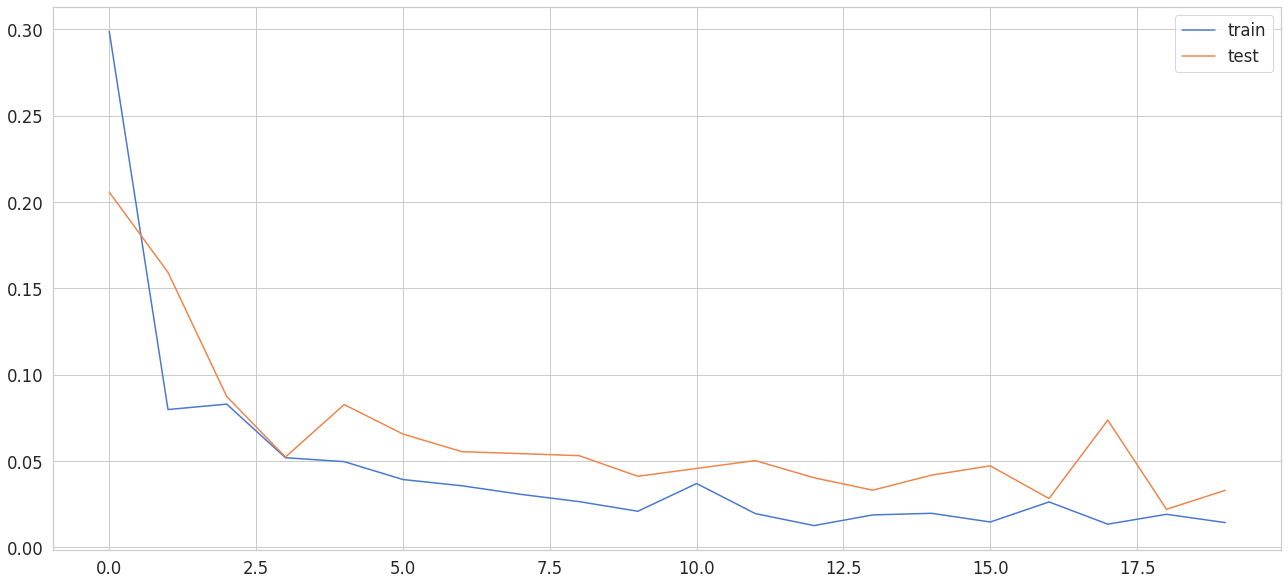

In [54]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [55]:
model.evaluate(x_test, y_test)

29/29 [==============================] - 0s 5ms/step - loss: 0.0163 - acc: 0.9945


[0.016282467171549797, 0.9944506287574768]

In [56]:
# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmprzenfxs6/assets


INFO:tensorflow:Assets written to: /tmp/tmprzenfxs6/assets


In [57]:
# Save the model
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [61]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd

# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i /content/model.tflite > model.h

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

# Testing

In [ ]:
pred_filepath = "lying_down.csv"

pred_features_df = calc_features_df(pred_filepath, is_raw=False)

pred_features_df.head()

In [ ]:
x = pred_features_df.to_numpy().reshape((pred_features_df.shape[0], pred_features_df.shape[1], 1))

prediction = np.argmax(model.predict(x), axis=-1)[0]

if prediction == 0:
  print("ADL")
elif prediction == 1:
  print("Fall")

# Data Visualization

In [ ]:
# Adapted from: https://curiousily.com/posts/time-series-classification-for-human-activity-recognition-with-lstms-in-keras/

def plot_activity(df: pd.DataFrame, title: str):
    data = df[['gyro_x', 'gyro_y', 'gyro_z']][:500]
    graph = data.plot(title=title)
    graph.legend(loc='lower left', bbox_to_anchor=[1.0, 0.5])

In [ ]:
vis_df = pd.read_csv("/content/fall-detection/dataset/SA01/F01_SA01_R01.csv", names=COLUMN_NAMES, header=None)
# vis_df = pd.read_csv("/content/lying_down.csv", names=COLUMN_NAMES, header=None)

# Convert data
for axis in ["x", "y", "z"]:
  vis_df[f"acc1_{axis}"] = convert_data(vis_df[f"acc1_{axis}"], 16, 13)
  vis_df[f"acc2_{axis}"] = convert_data(vis_df[f"acc2_{axis}"], 8, 14)
  vis_df[f"gyro_{axis}"] = convert_data(vis_df[f"gyro_{axis}"], 2000, 16)

vis_df_before = vis_df.copy(deep=True)

# Filter data using a Butterworth filter
for axis in ["x", "y", "z"]:
  vis_df[f"acc1_{axis}"] = filter_data(vis_df[f"acc1_{axis}"])
  vis_df[f"acc2_{axis}"] = filter_data(vis_df[f"acc2_{axis}"])
  vis_df[f"gyro_{axis}"] = filter_data(vis_df[f"gyro_{axis}"])

In [ ]:
plot_activity(vis_df_before, "Before")

In [ ]:
plot_activity(vis_df, "After")